In [1]:
!pip install neuralprophet -q
!pip install prophet -q

     |████████████████████████████████| 74 kB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 54.5 MB/s 


## Summary of Results

LSTM performed the best after fine-tuning. Non-deep models may not perform as well due to the strong assumption of seasonality.

| **Model** | **MAE** | **RMSE** |
|---|---|---|
| Neural Prophet (clipped test) | 77 | 92 |
| Neural Prophet (non-clipped test) | 82 | 153 |
| FB Prophet (clipped test) | 90 | 106 |
| FB Prophet (non-clipped test) | 96 | 160 |
| *LSTM (clipped test)*  | *71* | *88* |
| LSTM (non-clipped train, clipped test) | 72 | 89 |

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from neuralprophet import NeuralProphet
from prophet import Prophet

In [34]:
def mae(x):
  return np.mean(np.abs(x))

def rmse(x):
  return np.sqrt(np.mean(np.square(x)))

## EDA

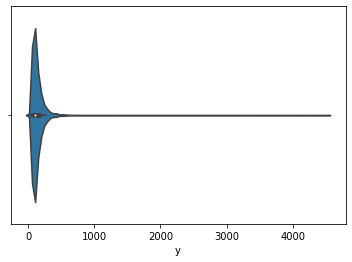

In [6]:
df = pd.read_feather('/content/drive/MyDrive/wep_2012_22.feather')
df = df[['DATETIME', 'WEP ($/MWh)']]
df.columns = ['ds', 'y']

sb.violinplot(x=df['y']);

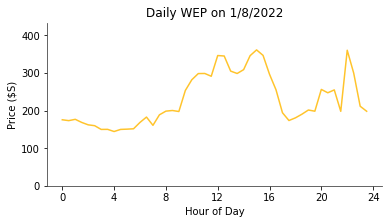

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3), facecolor='none')
df_plot = df[(df['ds'] < '2022-08-02') & (df['ds'] >= f'2022-08-01')]
plt.plot(df_plot.ds, df_plot.y, color='#FFC42C')
xmin = axes.get_xticks()[0]
plt.xticks(np.linspace(xmin, xmin+1, 7), np.linspace(0, 24, 7).astype(int))
plt.ylim([0, df_plot.y.max()*1.2])

plt.title('Daily WEP on 1/8/2022')
plt.ylabel('Price ($S)')
plt.xlabel('Hour of Day')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_color('#404040')
axes.spines['left'].set_color('#404040')

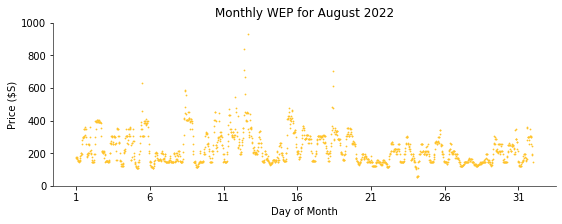

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(9, 3), facecolor='none')
df_plot = df[(df['ds'] < '2022-09-01') & (df['ds'] >= f'2022-08-01')]
plt.scatter(df_plot.ds, df_plot.y, color='#FFC42C', alpha=1, s=0.6)
xmin = axes.get_xticks()[0]
plot_days = np.array([1, 6, 11, 16, 21, 26, 31])
plt.xticks(plot_days+xmin-1, plot_days)
plt.ylim([0, 1000])

plt.title('Monthly WEP for August 2022')
plt.ylabel('Price ($S)')
plt.xlabel('Day of Month')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_color('#404040')
axes.spines['left'].set_color('#404040')

## Neural Prophet

We use Neural Prophet to help us determine preprocessing steps.

In [54]:
def neural_prophet_experiment(start_year: int, clip_values: bool):
                              
    df = pd.read_feather('/content/drive/MyDrive/wep_2012_22.feather')
    df = df[['DATETIME', 'WEP ($/MWh)']]
    df.columns = ['ds', 'y']
    max_price = df.y.median() + 3*df.y.std()

    df_train = df[(df['ds'] < '2022-08-01') & (df['ds'] >= f'{start_year}-01-01')]
    df_test = df[(df['ds'] >= '2022-08-01')]
    if clip_values:
        df_train['y'] = df_train['y'].apply(lambda x: max_price if x > max_price else x)
    df_test['y'] = df_test['y'].apply(lambda x: max_price if x > max_price else x)

    m = NeuralProphet()
    metrics = m.fit(df_train)

    forecast = m.predict(df_test)
    return mae(forecast.residual1), rmse(forecast.residual1)

In [ ]:
results_neural_prophet = []

for yr in [2012, 2020, 2021, 2022]:
    for clip_bool in [True, False]:
        mae, rmse = neural_prophet_experiment(start_year=yr, clip_values=clip_bool)
        results_neural_prophet.append({
            'start_year': yr,
            'clip_outliers': clip_bool,
            'mae': mae,
            'rmse': rmse,
        })

In [ ]:
pd.DataFrame(results_neural_prophet)

We conclude that start year of 2021 and NOT clipping the outliers is the best pre-processing method

In [44]:
df = pd.read_feather('/content/drive/MyDrive/wep_2012_22.feather')
df = df[['DATETIME', 'WEP ($/MWh)']]
df.columns = ['ds', 'y']
max_price = df.y.median() + 3*df.y.std()

df_train = df[(df['ds'] < '2022-08-01') & (df['ds'] >= f'2021-01-01')]
df_test = df[(df['ds'] >= '2022-08-01')]
df_test['y'] = df_test['y'].apply(lambda x: max_price if x > max_price else x)

m = NeuralProphet()
metrics = m.fit(df_train)

forecast = m.predict(df_test)
print(f'\nMAE={mae(forecast.residual1)}, RMSE={rmse(forecast.residual1)}')

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.996% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.996% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 30T
INFO:NP.df_utils:Dataframe freq automatically defined as 30T
INFO - (NP.config.init_d

  0%|          | 0/161 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.59E-01, min: 5.46E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.59E-01, min: 5.46E-02


  0%|          | 0/161 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.59E-01, min: 5.46E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.59E-01, min: 5.46E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.88E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.88E-01
Epoch[79/79]: 100%|██████████| 79/79 [01:08<00:00,  1.15it/s, SmoothL1Loss=0.0759, MAE=127, RMSE=289, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.957% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T
INFO:NP.df_utils:Defined frequency is equal to major frequency - 30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.957% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is eq


MAE=76.98725682267138, RMSE=92.27152935800981


In [45]:
df = pd.read_feather('/content/drive/MyDrive/wep_2012_22.feather')
df = df[['DATETIME', 'WEP ($/MWh)']]
df.columns = ['ds', 'y']
max_price = df.y.median() + 3*df.y.std()

df_train = df[(df['ds'] < '2022-08-01') & (df['ds'] >= f'2021-01-01')]
df_test = df[(df['ds'] >= '2022-08-01')]
# df_test['y'] = df_test['y'].apply(lambda x: max_price if x > max_price else x)

m = NeuralProphet()
metrics = m.fit(df_train)

forecast = m.predict(df_test)
print(f'\nMAE={mae(forecast.residual1)}, RMSE={rmse(forecast.residual1)}')

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.996% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.996% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 30T
INFO:NP.df_utils:Dataframe freq automatically defined as 30T
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO:NP.config:Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 79
INFO:NP.config:Auto-set epochs to 79


  0%|          | 0/161 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.54E-01, min: 3.03E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.54E-01, min: 3.03E+00


  0%|          | 0/161 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.54E-01, min: 3.03E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.54E-01, min: 3.03E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.33E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.33E-01
Epoch[79/79]: 100%|██████████| 79/79 [01:07<00:00,  1.16it/s, SmoothL1Loss=0.0759, MAE=127, RMSE=289, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.957% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T
INFO:NP.df_utils:Defined frequency is equal to major frequency - 30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.957% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is eq


MAE=82.6349030630929, RMSE=152.82701614335954


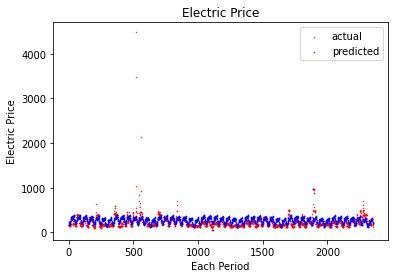

In [16]:
plt.scatter(range(len(df_test)), df_test.y, s=0.2, color = 'red', label = 'actual')
plt.scatter(range(len(df_test)), forecast.yhat1, s=0.2, color = 'blue', label = 'predicted')
plt.title('Electric Price')
plt.xlabel('Each Period')
plt.ylabel("Electric Price")
plt.legend()
plt.show()


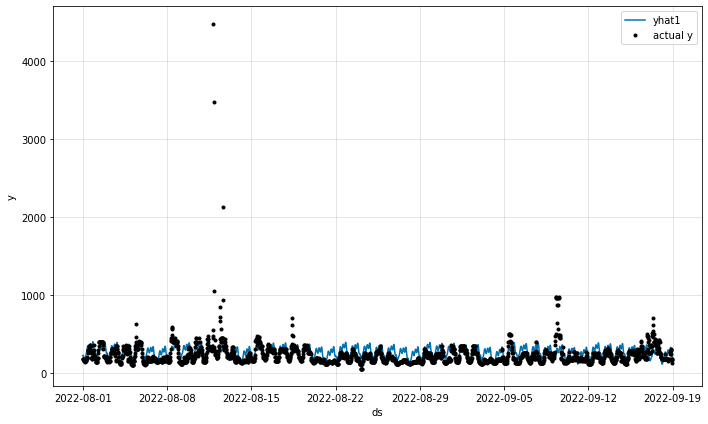

In [17]:
fig_forecast = m.plot(forecast)

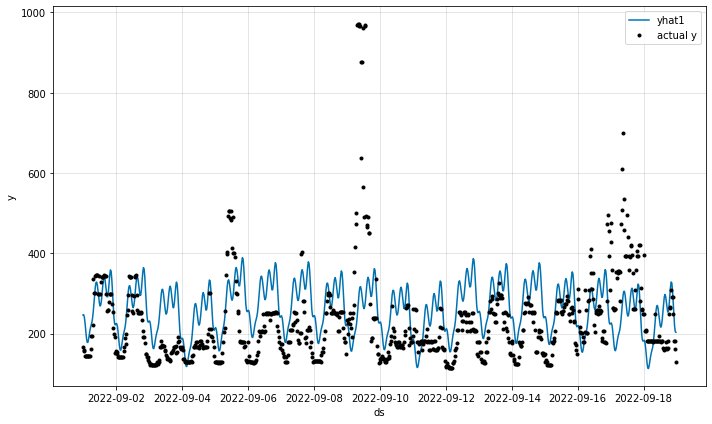

In [18]:
fig_forecast = m.plot(forecast[forecast['ds'] >= '2022-09-01'])

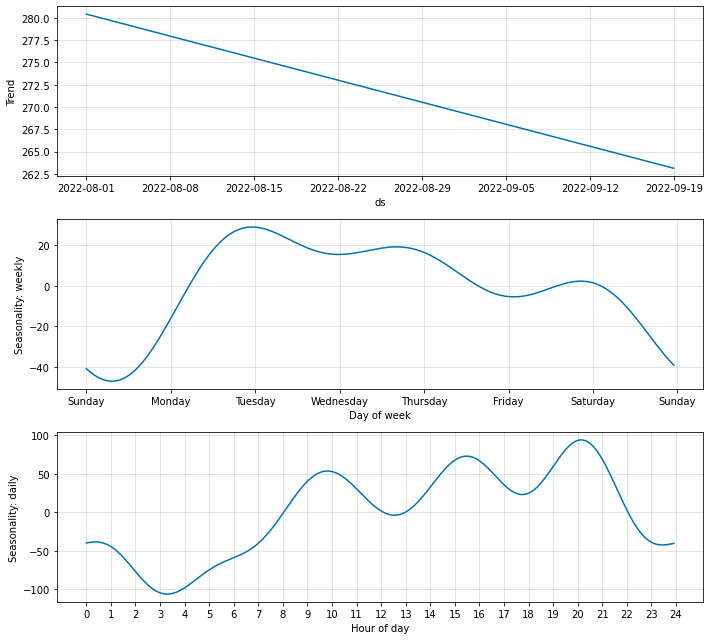

In [19]:
fig_components = m.plot_components(forecast)

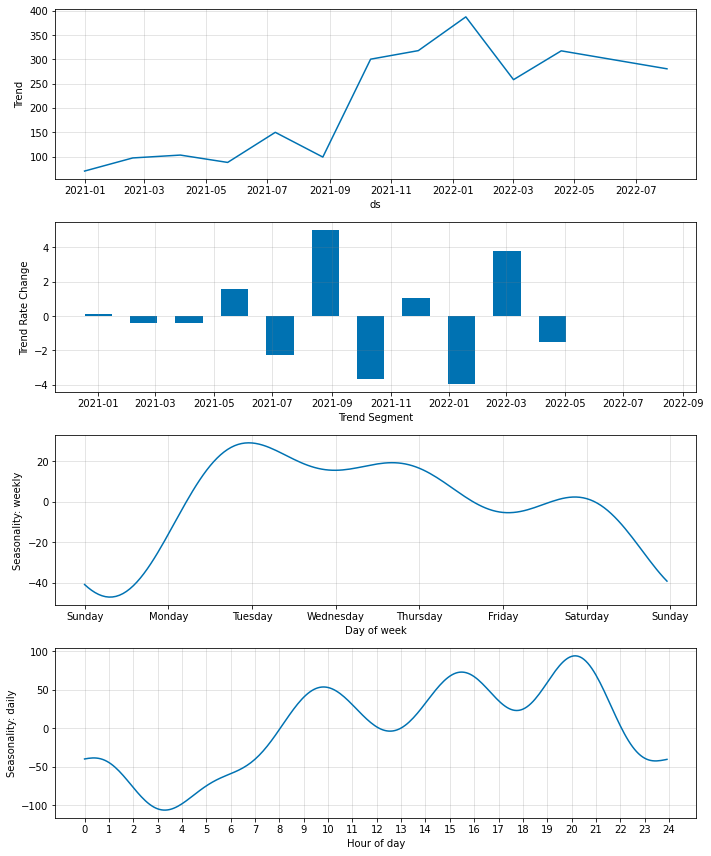

In [20]:
fig_model = m.plot_parameters()

## Facebook Prophet

In [53]:
df = pd.read_feather('/content/drive/MyDrive/wep_2012_22.feather')
df = df[['DATETIME', 'WEP ($/MWh)']]
df.columns = ['ds', 'y']
max_price = df.y.median() + 3*df.y.std()

df_train = df[(df['ds'] < '2022-08-01') & (df['ds'] >= f'2021-01-01')]
df_test = df[(df['ds'] >= '2022-08-01')]
# df_test['y'] = df_test['y'].apply(lambda x: max_price if x > max_price else x)

m = Prophet()
metrics = m.fit(df_train)

forecast = m.predict(df_test)
print(f'\nMAE={mae(forecast.yhat-np.array(df_test.y))}, RMSE={rmse(forecast.yhat-np.array(df_test.y))}')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz03_mxy/c714b7wn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz03_mxy/9li_4514.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74997', 'data', 'file=/tmp/tmpnz03_mxy/c714b7wn.json', 'init=/tmp/tmpnz03_mxy/9li_4514.json', 'output', 'file=/tmp/tmppiemliku/prophet_model-20221002205941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:59:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



MAE=96.43849473782049, RMSE=160.66702778922317


In [46]:
df = pd.read_feather('/content/drive/MyDrive/wep_2012_22.feather')
df = df[['DATETIME', 'WEP ($/MWh)']]
df.columns = ['ds', 'y']
max_price = df.y.median() + 3*df.y.std()

df_train = df[(df['ds'] < '2022-08-01') & (df['ds'] >= f'2021-01-01')]
df_test = df[(df['ds'] >= '2022-08-01')]
df_test['y'] = df_test['y'].apply(lambda x: max_price if x > max_price else x)

m = Prophet()
metrics = m.fit(df_train)

forecast = m.predict(df_test)
print(f'\nMAE={mae(forecast.yhat-np.array(df_test.y))}, RMSE={rmse(forecast.yhat-np.array(df_test.y))}')

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz03_mxy/t2rz0nwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz03_mxy/pbhlqwt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/


MAE=90.65114785278259, RMSE=106.03147074962365


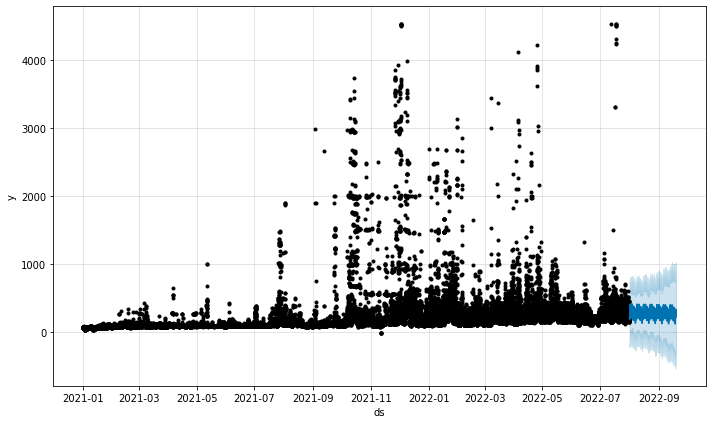

In [22]:
fig_forecast = m.plot(forecast)

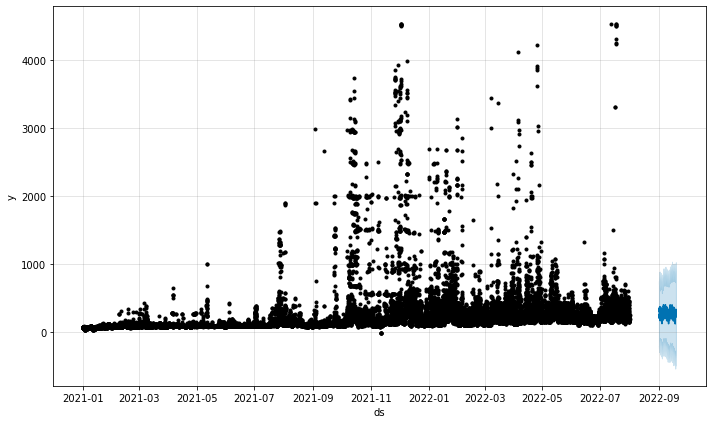

In [23]:
fig_forecast = m.plot(forecast[forecast['ds'] >= '2022-09-01'])

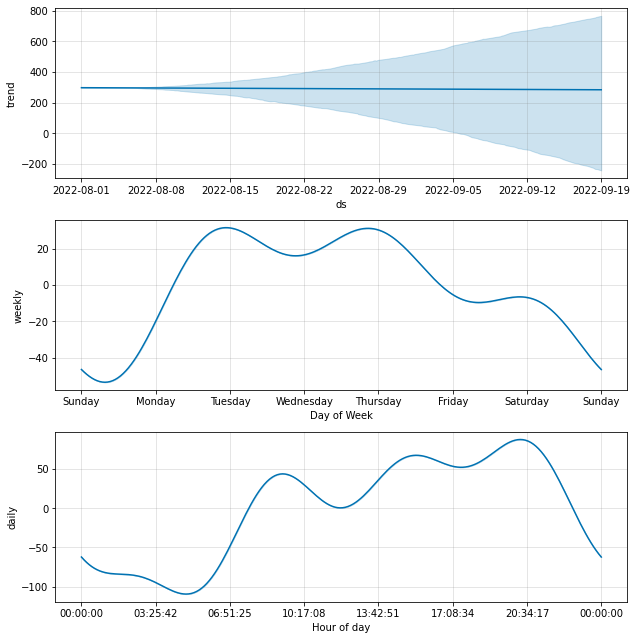

In [24]:
fig_components = m.plot_components(forecast)

## LSTM Method

In [25]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 

In [29]:
df = pd.read_feather('/content/drive/MyDrive/wep_2012_22.feather')
df = df[['DATETIME', 'WEP ($/MWh)']]
df.columns = ['ds', 'y']
max_price = df.y.median() + 3*df.y.std()

df_train = df[(df['ds'] < '2022-08-01') & (df['ds'] >= f'2021-01-01')]
df_test = df[(df['ds'] >= '2022-08-01')]
df_train['y'] = df_train['y'].apply(lambda x: max_price if x > max_price else x)
df_test['y'] = df_test['y'].apply(lambda x: max_price if x > max_price else x)

# Preprocessing the data
sc = MinMaxScaler(feature_range = (0,1)) 
training_values = df_train['y'].values.reshape(-1, 1)
training_scaled_values = sc.fit_transform(training_values)

# We use 30 days prior as past input, to predict the 10th day in the future
DAYS_BEFORE = 30
DAYS_IN_FUTURE = 10

X_train = []
y_train = []

for i in range(48*DAYS_BEFORE, len(training_scaled_values)-48*DAYS_IN_FUTURE, 48):
  X_train.append(training_scaled_values[i-48*DAYS_BEFORE:i]) 
  y_train.append(training_scaled_values[i+48*DAYS_IN_FUTURE:i+48*(DAYS_IN_FUTURE+1)])

# Shuffle the training data
np.random.seed(7)
np.random.shuffle(X_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

X_train, y_train = np.array(X_train), np.squeeze(np.array(y_train))
X_train = np.reshape(X_train, (X_train.shape[0], 48*DAYS_BEFORE, 1))

# Get the test data
testing_values = df_test['y'].values.reshape(-1,1)
testing_scaled_values = sc.transform(testing_values)

X_test = []
y_test = []

for i in range(48*DAYS_BEFORE, len(testing_scaled_values)-48*DAYS_IN_FUTURE, 48):
  X_test.append(testing_scaled_values[i-48*DAYS_BEFORE:i]) 
  y_test.append(testing_scaled_values[i+48*DAYS_IN_FUTURE:i+48*(DAYS_IN_FUTURE+1)])

X_test, y_test = np.array(X_test), np.squeeze(np.array(y_test))
X_test = np.reshape(X_test, (X_test.shape[0], 48*DAYS_BEFORE, 1))

model = tf.keras.Sequential([
    LSTM(80, return_sequences=True, input_shape=(48*DAYS_BEFORE, 1)),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(48)
])

def rmse_loss(y_true, y_pred):
    return tf.square(tf.math.reduce_mean(tf.square(y_true - y_pred)))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=rmse_loss,
)

## Create checkpoints
checkpoint_save_path = "./DLW0001.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_save_path,
    save_weights_only= True,
    save_best_only= True,
    monitor = 'loss'
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

((537, 1440, 1), (9, 1440, 1), (537, 48), (9, 48))

In [30]:
# Training
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, callbacks = [cp_callback])

Epoch 1/10
17/17 [==============================] - 5s 95ms/step - loss: 0.0186
Epoch 2/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0036
Epoch 3/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0028
Epoch 4/10
17/17 [==============================] - 2s 112ms/step - loss: 0.0026
Epoch 5/10
17/17 [==============================] - 2s 97ms/step - loss: 0.0025
Epoch 6/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0024
Epoch 7/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0023
Epoch 8/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0022
Epoch 9/10
17/17 [==============================] - 2s 90ms/step - loss: 0.0022
Epoch 10/10
17/17 [==============================] - 2s 89ms/step - loss: 0.0022


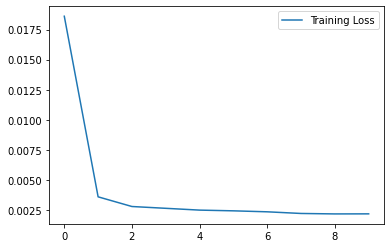

In [42]:
# Visualize loss
loss = history.history['loss']

plt.figure()
plt.plot(loss, label = "Training Loss")
plt.legend()
plt.show()

In [43]:
y_pred = model.predict(X_test)
y_pred = sc.inverse_transform(y_pred) 
y_real = sc.inverse_transform(y_test)

print(f'\nMAE={mae(y_pred-y_real)}, RMSE={rmse(y_pred-y_real)}')


MAE=71.6982567993253, RMSE=88.80153763534803


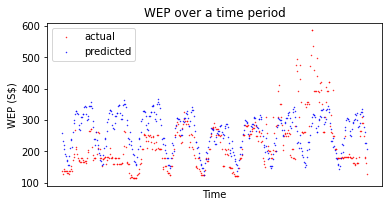

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3), facecolor='none')
plt.scatter(range(len(y_real.reshape(-1))), y_real.reshape(-1), s=0.2, color = 'red', label = 'actual')
plt.scatter(range(len(y_real.reshape(-1))), y_pred.reshape(-1), s=0.2, color = 'blue', label = 'predicted')
plt.title('WEP over a time period')
plt.xlabel('Time')
plt.xticks([])
plt.ylabel('WEP (S$)')
plt.legend()
plt.show()

In [51]:
## NO CLIP: TRAINING

df = pd.read_feather('/content/drive/MyDrive/wep_2012_22.feather')
df = df[['DATETIME', 'WEP ($/MWh)']]
df.columns = ['ds', 'y']
max_price = df.y.median() + 3*df.y.std()

df_train = df[(df['ds'] < '2022-08-01') & (df['ds'] >= f'2021-01-01')]
df_test = df[(df['ds'] >= '2022-08-01')]
df_train['y'] = df_train['y'].apply(lambda x: max_price if x > max_price else x)
df_test['y'] = df_test['y'].apply(lambda x: max_price if x > max_price else x)

# Preprocessing the data
sc = MinMaxScaler(feature_range = (0,1)) 
training_values = df_train['y'].values.reshape(-1, 1)
training_scaled_values = sc.fit_transform(training_values)

# We use 30 days prior as past input, to predict the 10th day in the future
DAYS_BEFORE = 30
DAYS_IN_FUTURE = 10

X_train = []
y_train = []

for i in range(48*DAYS_BEFORE, len(training_scaled_values)-48*DAYS_IN_FUTURE, 48):
  X_train.append(training_scaled_values[i-48*DAYS_BEFORE:i]) 
  y_train.append(training_scaled_values[i+48*DAYS_IN_FUTURE:i+48*(DAYS_IN_FUTURE+1)])

# Shuffle the training data
np.random.seed(7)
np.random.shuffle(X_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

X_train, y_train = np.array(X_train), np.squeeze(np.array(y_train))
X_train = np.reshape(X_train, (X_train.shape[0], 48*DAYS_BEFORE, 1))

# Get the test data
testing_values = df_test['y'].values.reshape(-1,1)
testing_scaled_values = sc.transform(testing_values)

X_test = []
y_test = []

for i in range(48*DAYS_BEFORE, len(testing_scaled_values)-48*DAYS_IN_FUTURE, 48):
  X_test.append(testing_scaled_values[i-48*DAYS_BEFORE:i]) 
  y_test.append(testing_scaled_values[i+48*DAYS_IN_FUTURE:i+48*(DAYS_IN_FUTURE+1)])

X_test, y_test = np.array(X_test), np.squeeze(np.array(y_test))
X_test = np.reshape(X_test, (X_test.shape[0], 48*DAYS_BEFORE, 1))

model = tf.keras.Sequential([
    LSTM(80, return_sequences=True, input_shape=(48*DAYS_BEFORE, 1)),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(48)
])

def rmse_loss(y_true, y_pred):
    return tf.square(tf.math.reduce_mean(tf.square(y_true - y_pred)))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=rmse_loss,
)

## Create checkpoints
checkpoint_save_path = "./DLW0001.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_save_path,
    save_weights_only= True,
    save_best_only= True,
    monitor = 'loss'
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

((537, 1440, 1), (9, 1440, 1), (537, 48), (9, 48))

In [52]:
# Training
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, callbacks = [cp_callback])

y_pred = model.predict(X_test)
y_pred = sc.inverse_transform(y_pred) 
y_real = sc.inverse_transform(y_test)

print(f'\nMAE={mae(y_pred-y_real)}, RMSE={rmse(y_pred-y_real)}')

Epoch 1/10
17/17 [==============================] - 4s 95ms/step - loss: 0.0186
Epoch 2/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0036
Epoch 3/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0028
Epoch 4/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0026
Epoch 5/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0025
Epoch 6/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0024
Epoch 7/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0023
Epoch 8/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0022
Epoch 9/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0022
Epoch 10/10
17/17 [==============================] - 2s 90ms/step - loss: 0.0022

MAE=71.6982567993253, RMSE=88.80153763534803


## Oct Data

We only managed to tune LSTM to perform better than Neural Prophet at the end, so this temp output was used for the other components of the project.

In [48]:
import uuid
import pandas as pd
from neuralprophet import NeuralProphet

In [49]:
df = pd.read_feather('/content/drive/MyDrive/wep_2012_22.feather')
df = df[['DATETIME', 'WEP ($/MWh)']]
df.columns = ['ds', 'y']
max_price = df.y.median() + 3*df.y.std()
df_train = df[(df['ds'] < '2022-09-18') & (df['ds'] >= f'2021-01-01')]

m = NeuralProphet()
metrics = m.fit(df_train)

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.997% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 30T
INFO:NP.df_utils:Dataframe freq automatically defined as 30T
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO:NP.config:Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 78
INFO:NP.config:Auto-set epochs to 78


  0%|          | 0/161 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.06E-02, min: 8.29E-01
INFO:NP.utils_torch:lr-range-test results: steep: 8.06E-02, min: 8.29E-01


  0%|          | 0/161 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.17E-02, min: 7.29E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.17E-02, min: 7.29E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.04E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 9.04E-02
Epoch[78/78]: 100%|██████████| 78/78 [01:20<00:00,  1.04s/it, SmoothL1Loss=0.0747, MAE=121, RMSE=280, RegLoss=0]


In [50]:
df_future = m.make_future_dataframe(df, periods=48*30)
forecast = m.predict(df_future)[['ds', 'yhat1']]
forecast['id'] = pd.Series([str(uuid.uuid4()) for _ in range(len(forecast))])
forecast = forecast.iloc[:, [2,0,1]]
forecast.columns = ['id', 'timestamp', 'price']
forecast.to_csv('/content/drive/MyDrive/wep_forecast.csv', index=False)

forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T
INFO:NP.df_utils:Defined frequency is equal to major frequency - 30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.931% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.931% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T
INFO:NP.df_utils:Defined frequency is equal to major frequency - 30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.931% of the data.
INFO:NP.df_utils:Major frequency 30T corresponds to 99.931% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T
INFO:NP.df_utils:Defined frequency is equal to major frequency - 30T


,id,timestamp,price
0,7396fc0b-1f83-4af1-8772-2b5d4d5473dd,2022-09-19 00:00:00,172.522049
1,6c7155b5-9c6c-4947-bd92-9f4255d06ea5,2022-09-19 00:30:00,175.020905
2,0e12c025-dbe6-439d-95e5-b65feaaee5ae,2022-09-19 01:00:00,171.176010
3,cbc0bb28-be0f-423b-80c3-e0cf607629ce,2022-09-19 01:30:00,159.839279
4,ab01b728-c20f-401b-ae9f-cc36cae48a53,2022-09-19 02:00:00,144.073547
...,...,...,...
1435,a993bcaf-a1dc-4009-badc-b54b3b6e94b0,2022-10-18 21:30:00,257.482025
1436,761dae0a-ea6d-4a47-9b46-42e94fe7f2bd,2022-10-18 22:00:00,225.137833
1437,53ebc7b6-49ff-4fc9-902e-406fda746cc6,2022-10-18 22:30:00,199.560989
1438,e2fe9408-ee68-4dbb-9785-acff94f7b83f,2022-10-18 23:00:00,185.383530
